In [1]:
import torch

## autograd

torch.Tensor is the central class of the package. If you set its attribute .requires_grad as True, it starts to track all operations on it. When you finish your computation you can call .backward() and have all the gradients computed automatically. The gradient for this tensor will be accumulated into .grad attribute.

To stop a tensor from tracking history, you can call .detach() to detach it from the computation history, and to prevent future computation from being tracked.

To prevent tracking history (and using memory), you can also wrap the code block in with torch.no_grad():. This can be particularly helpful when evaluating a model because the model may have trainable parameters with requires_grad=True, but for which we don’t need the gradients.

Tensor and Function are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a .grad_fn attribute that references a Function that has created the Tensor (except for Tensors created by the user - their grad_fn is None).

If you want to compute the derivatives, you can call .backward() on a Tensor. If Tensor is a scalar (i.e. it holds a one element data), you don’t need to specify any arguments to backward(), however if it has more elements, you need to specify a gradient argument that is a tensor of matching shape.

In [2]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
y = x + 2
print(y)
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward1>)


In [3]:
#Let’s backprop now. Because out contains a single scalar, out.backward() is equivalent to out.backward(torch.tensor(1.)).

out.backward()

#Print gradients d(out)/dx

print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of 4.5. Let’s call the out Tensor “o”. We have that 
- o=(1/4)∑(z<sub>i</sub>)
- z<sub>i</sub>=3(x<sub>i</sub>+2)<sup>2</sup>
- ∂o/∂x<sub>i</sub>=(1/4)(3*2)(x<sub>i</sub>+2), hence ∂o/∂x<sub>i</sub>=9/2=4.5.

## Neural network

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [9]:
input = torch.randn(1, 1, 32, 32) #fake data
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output

In [10]:
criterion = nn.MSELoss()

import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## data

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Files already downloaded and verified


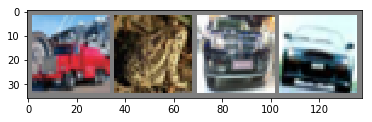

truck  frog   car   car


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
len(trainset) , len(testset)

(50000, 10000)

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.232
[1,  4000] loss: 1.866
[1,  6000] loss: 1.653
[1,  8000] loss: 1.536
[1, 10000] loss: 1.499
[1, 12000] loss: 1.445
[2,  2000] loss: 1.351
[2,  4000] loss: 1.329
[2,  6000] loss: 1.315
[2,  8000] loss: 1.273
[2, 10000] loss: 1.274
[2, 12000] loss: 1.252
Finished Training


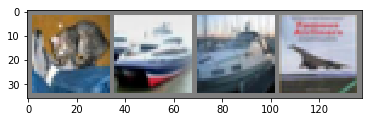

GroundTruth:    cat  ship  ship plane


In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [23]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [25]:
#Hmmm, what are the classes that performed well, and the classes that did not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 63 %
Accuracy of  bird : 50 %
Accuracy of   cat : 41 %
Accuracy of  deer : 44 %
Accuracy of   dog : 50 %
Accuracy of  frog : 51 %
Accuracy of horse : 72 %
Accuracy of  ship : 69 %
Accuracy of truck : 55 %


## to gpu

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

# Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

net.to(device)

# Remember that you will have to send the inputs and targets at every step to the GPU too:

inputs, labels = inputs.to(device), labels.to(device)

### model saving ways
- https://pytorch.org/tutorials/beginner/saving_loading_models.html

### transfer learning
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

### NLP  pytorch
- https://pytorch.org/tutorials/beginner/chatbot_tutorial.html